In [104]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
from scipy import fftpack
from scipy.integrate import solve_bvp
from scipy import special as sp
import plasmapy.mathematics
import scipy.optimize as op
from functools import partial
from scipy import integrate
%config InlineBackend.figure_format = 'png'
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from matplotlib.animation import FFMpegFileWriter
#%matplotlib notebook

In [336]:
tem = 1
L = 200
vmax = 10  # 10 * np.sqrt(tem)
grid_num = 500
N = 200000

nx = 51
nv = 21
dx = L/(nx-0)
dv = 2*vmax/(nv-0)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.1
max_steps  = 1000
data_steps = 5
data_num = int(max_steps/data_steps)
uae = 0.6
uai = 0.52


path = '../data/'

m=1
n=N/L
q=np.sqrt(1/n)
v_th = np.sqrt(2*tem)
l_D = np.sqrt( tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

data_num =  200


In [337]:
k = 2*np.pi/L
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
#kvec = np.arange(.1,1.2,0.1)
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
v_p = s.x[0]/k
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("rt = ", abs(s.x[1]/np.sqrt(abs(uae-uai))))
print("1/r = ", abs(1/s.x[1]))
print('rtime = ', max_steps*dt)

k =  0.031415926535897934
w_r =  1.0014822759845168
w_i =  -3.1920953223045716e-14
v_p =  31.878170928371517
rt =  1.1285761242977105e-13
1/r =  31327385276140.125
rtime =  100.0


## 理论预测

In [338]:
def fm(v, t):
    #vm = np.sqrt(3)
    #r = 0.0
    #if v>=-vm and v<=vm:
        #r = 0.5 / vm
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def ue(x):
    r = 1.+uae*np.cos(2.*np.pi*x/L)
    return r
def ui(x):
    r = 1.+uai*np.cos(2.*np.pi*x/L)
    return r

In [339]:
#theoretical energy
def efield2(x):
    r =( (N/L)*q*(uai-uae) * np.sin(k*x)/k )**2
    return r

ep_theo = 0.5*integrate.quad(efield2,0,L)[0]/N
ek_theo = 0.5*tem

einit_theo=ek_theo+ep_theo

print("Ek = ",ek_theo)
print("Ep = ",ep_theo)
print("Etot = ",einit_theo)

Ek =  0.5
Ep =  1.6211389382774022
Etot =  2.121138938277402


In [340]:
def entropy(x,v):
    ufv = fm(v, tem)*ue(x)/L
    if (ufv==0.0):
        r = 0.0
    else:
        r = -ufv * np.log(ufv)
    return r
options = {'limit':50000}
entropyt_int_res = integrate.nquad(entropy,[[0,L],[-np.inf,np.inf]], opts=[options,options])
entropyt=entropyt_int_res[0]
print(entropyt)

6.622616415410337


In [341]:
def ug(x):
    r = (1. + uai * np.cos(k*x)) #/ (2*1.*a)
    return r

def ug_dev(x):
    r = -uai*k*np.sin(k*x)#/ 2. / a
    return r

def eq4U(x,yy,p):
    kappa,t=p
    dy, y = yy
    k_factor = (kappa+2) / (kappa+1)
    dy2y = (dy**2) / y
    ddy = k_factor * dy2y + (kappa+1) / (kappa) * (y**k_factor) * ( y-ui(x) ) / t * n * (q**2)
    return np.vstack((ddy, dy))

def bc4U(ya, yb):
    return np.array([ya[0]-yb[0],ya[1]-yb[1]])

xi = np.linspace(0, L, num=5000, dtype='complex',endpoint=False)
yguess = np.array([ug_dev(xi), ui(xi)])

def eq4para(x,energy,entropy):
    kp,tp = x
    sol4ode = solve_bvp(partial(eq4U, p=x), bc4U, xi,
                        yguess, tol=1e-13, max_nodes=50000)

    def ff(x):
        return sol4ode.sol(x)[1]
    def ff_r(x):
        return ff(x).real
    def ff_i(x):
        return ff(x).imag

    def ff_inti(x):
        r = ff(x)**(kp/(kp+1))
        return r
    def ff_inti_r(x):
        return ff_inti(x).real
    def ff_inti_i(x):
        return ff_inti(x).imag
        
    def ff_intii(x):
        r = ui(x) * (ff(x) ** (-1.0/(kp+1)))
        return r
    def ff_intii_r(x):
        return ff_intii(x).real
    def ff_intii_i(x):
        return ff_intii(x).imag
    
    def ff_intiii(x):
        r = ff(x)**(-1./(kp+1))
        return r
    def ff_intiii_r(x):
        return ff_intiii(x).real
    def ff_intiii_i(x):
        return ff_intiii(x).imag
    
    def entropy_pred(x, v):
        U_x = ff(x)
        
        if(kp==0):
            t_x = tp
            tempf = U_x * fm(v, t_x)+0j
        else:
            t_x = tp * U_x ** (-1./(kp+1))
            tempf = U_x * fk(v, t_x, kp)/L+0j
        if (tempf == 0.0+0.0j):
            r = 0.0
        else:
            r = -tempf * np.log(tempf)
        r = -tempf * np.log(tempf)
        return r
    def entropy_pred_r(x,v):
        return entropy_pred(x,v).real
    def entropy_pred_i(x,v):
        return entropy_pred(x,v).imag
    entropy_pred_int_r = integrate.dblquad(
        entropy_pred_r, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropy_pred_int_i = integrate.dblquad(
        entropy_pred_i, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropyp = entropy_pred_int_r[0] + 1j * entropy_pred_int_i[0]

    int_ff_r = integrate.quad(ff_r, 0, L, epsrel=1e-10)[0]-1.0
    int_ff_i = integrate.quad(ff_i, 0, L, epsrel=1e-10)[0]-1.0
    int_ff = int_ff_r + 1j * int_ff_i
    
    int_i_r = integrate.quad(ff_inti_r, 0, L, epsrel=1e-10)[0]
    int_i_i = integrate.quad(ff_inti_i, 0, L, epsrel=1e-10)[0]
    int_i = int_i_r + 1j * int_i_i

    int_ii_r = integrate.quad(ff_intii_r, 0, L, epsrel=1e-10)[0]
    int_ii_i = integrate.quad(ff_intii_i, 0, L, epsrel=1e-10)[0]
    int_ii = int_ii_r + 1j * int_ii_i

    int_iii_r = integrate.quad(ff_intiii_r, 0, L, epsrel=1e-10)[0]
    int_iii_i = integrate.quad(ff_intiii_i, 0, L, epsrel=1e-10)[0] 
    int_iii = (int_iii_r + 1j * int_iii_i) * int_ff

    eq1 = ((energy*2)*L - tp * (1+kp) * int_i + tp * kp * int_ii)/(energy*2)/L
    eq2 = (entropyp-entropy)/entropy

    return eq1.real,eq2.real

In [342]:
para_guess = [0.14708099,2.83689694]# initial guess of parameters
#para_guess = [0.09231278,4.24309375]# initial guess of parameters
#para_guess = [0.16053615,2.82462186]
para_guess = [0.014708099,28.3689694]
#para_guess = [1.58007365e-02,2.12643938e+01]

sol_para = op.root(partial(eq4para,energy=einit_theo,entropy=entropyt), para_guess, method='hybr')

#sol_para = op.root(partial(eq4para,energy=efin,entropy=entropyt), para_guess, method='hybr')
para = sol_para.x

print(para)
print(sol_para.fun,sol_para.success)

[0.09772783 4.26818738]
[-1.42233231e-13 -1.19749425e-12] True


## 模拟结果

In [307]:
progesses = np.arange(0,data_num,1)

xdata = []
vdata = []

for progess in progesses:
    x_temp = np.loadtxt(os.path.join(path,"electronsx_data"+str(progess)))
    xdata.append(x_temp)
    v_temp = np.loadtxt(os.path.join(path,"electronsv_data"+str(progess)))
    vdata.append(v_temp)

In [308]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

In [319]:
def pdf(data,data_bins):##统计分布函数
    f, edges = np.histogram(data, bins=data_bins, density=True)
    x = (edges[0:len(edges)-1]+edges[1:len(edges)])/2
    dx = edges[1]-edges[0]
    return f, x, dx
def pdf2d(x,y,datax_bins,datay_bins):
    f,xedges,yedges = np.histogram2d(x,y,bins=[datax_bins,datay_bins],density=True)
    x = (xedges[0:len(xedges)-1]+xedges[1:len(xedges)])/2
    y = (yedges[0:len(yedges)-1]+yedges[1:len(yedges)])/2
    dx = xedges[1]-xedges[0]
    dy = yedges[1]-yedges[0]
    return f,x,y,dx,dy

In [320]:
print("Ek ",dataek[max_steps-1])
print("Ep ",dataep[max_steps-1])
print("Et ",dataet[max_steps-1])
def e(pdf,xw,vw):
    r = 0.0
    for x in pdf:
        for i in x:
            if i == 0.0:
                r += 0.0
            else: 
                r+=- i * np.log(i)
    return r * vw * xw
efin = dataet[max_steps-1]
entropyf = e(fxv,dx_fxv,dv_fxv)
print("S ",entropyf)

fxv, x_fxv, v_fxv, dx_fxv,dv_fxv = pdf2d(xdata[data_num-1],vdata[data_num-1],nx,nv)

Ek  0.9101171483744
Ep  0.005286433587332
Et  0.9154035819618
S  5.996059195206662


In [321]:
para_guess = [0.014708099,28.3689694]

sol_para = op.root(partial(eq4para,energy=efin,entropy=entropyf), para_guess, method='hybr')
para = sol_para.x
print(para)
print(sol_para.fun,sol_para.success)

[0.40390368 1.85880226]
[-6.37266008e-14 -2.33892575e-13] True


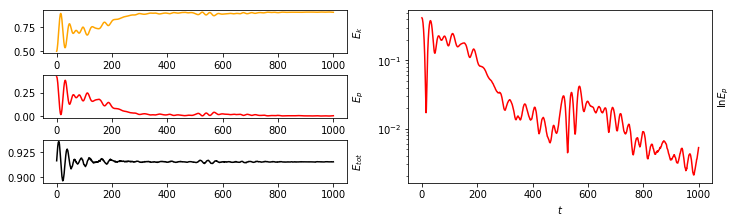

In [309]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

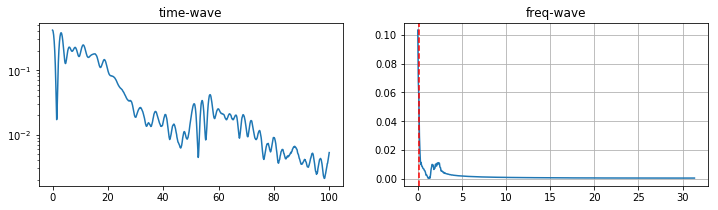

In [310]:
wave_start = max_steps-1000
wave_end = max_steps
wave_steps = wave_end - wave_start

t = np.linspace(0,wave_steps*dt,wave_steps)
yy = dataep[wave_start:wave_end]
n = wave_steps

def PlotWaveFreq(t,y):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)

    plt.figure(figsize=(12,3))
    ax1 = plt.subplot(121)
    ax1.plot(t,y)
    ax1.set_yscale('log')
    ax1.set_title('time-wave')
    ax2 = plt.subplot(122)
    ax2.plot(2*np.pi*x_k[0:n//2],2.0*np.abs(y_k[0:n//2]/n))
    ax2.axvline(s.x[0]/2/np.pi,color='red',ls='--')
    ax2.set_title('freq-wave')
    ax2.grid()
    plt.show()

PlotWaveFreq(t,yy)

### 初始分布函数fx fv

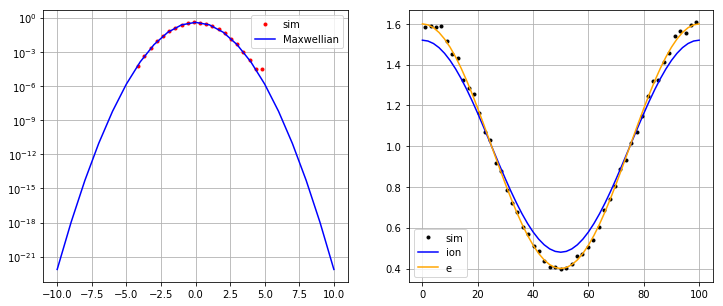

In [329]:
#initial VDF
fv0,v_fv0,dv_fv0 = pdf(vdata[0],nv)
fx0,x_fx0,dx_fx0 = pdf(xdata[0],nx)

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v_fv0,fv0,'.',color='r',label='sim')
ax1.plot(v,fm(v,tem),color='blue',label='Maxwellian')
ax1.set_yscale('log')

ax2.plot(x_fx0,fx0*L,'.',color='black',label='sim')
ax2.plot(x,ui(x),color='blue',label='ion')
ax2.plot(x,ue(x),color='orange',label='e')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

### 末态分布函数

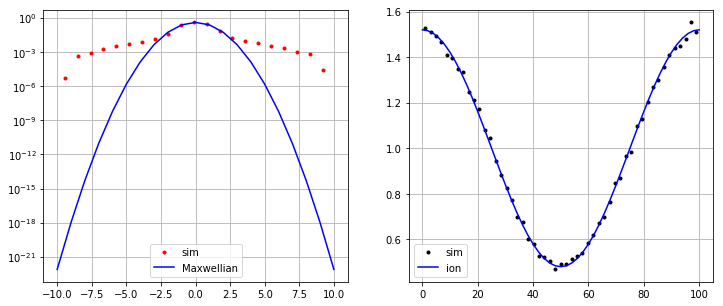

In [330]:
#data_num=10
#final VDF
fv,v_fv,dv_fv=pdf(vdata[data_num-1],nv)
fx,x_fx,dx_fx=pdf(xdata[data_num-1],nx)

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v_fv,fv,'.',color='r',label='sim')
ax1.plot(v,fm(v,tem),color='blue',label='Maxwellian')
ax1.set_yscale('log')

ax2.plot(x_fx,fx*L,'.',color='black',label='sim')
ax2.plot(x,ui(x),color='blue',label='ion')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

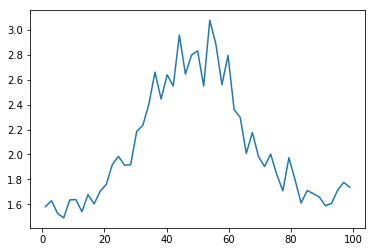

In [331]:
Z,x_Z,v_Z,dx_Z,dv_Z = pdf2d(xdata[data_num-1],vdata[data_num-1],nx,nv)
Zx = np.sum(Z,axis=1)*dv_Z
T = np.sum(v_Z**2*Z,axis=1)*dv_Z/Zx
plt.plot(x_Z,T)
plt.show()

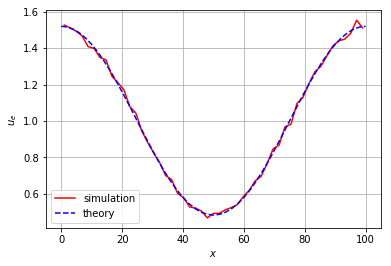

In [332]:
yguess = np.array([ug_dev(xi), ui(xi)])
sol = solve_bvp(partial(eq4U,p=para), bc4U, xi, yguess,tol=1e-13,max_nodes=50000)
def ff(x):
    return sol.sol(x)[1].real
ax1 = plt.gca()#subplot2grid((1, 2), (0, 0))

ax1.plot(x_fx,fx*L,'-',color='r',label=r'simulation')
#ax1.plot(x_Z,Zx*L,'.',color='black',label=r'simulation')
ax1.plot(x,ff(x),'--',label=r'theory',color='blue')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$u_e$')

ax1.legend()
ax1.grid()

plt.show()

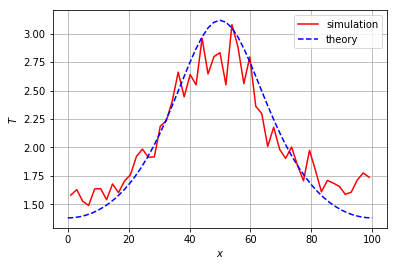

2.0565999160597617


In [333]:
def t_theo(x):
    return para[1]*(ff(x).real)**(-1.0/(para[0]+1))
    #return T.mean()*(ff(x).real)**(-1.0/(para[0]+1))

plt.plot(x_Z, T,'-',color='r',label='simulation')
plt.plot(x,t_theo(x), '--',color='blue', label = 'theory')
plt.xlabel(r'$x$')
plt.ylabel(r'$T$')
plt.legend()
plt.grid()
plt.show()
print(T.mean())

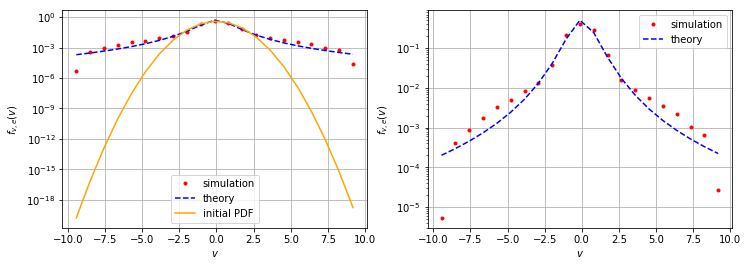

In [335]:
def fk_xv(x,v,k,t):
    if(k==0):
        s = ff(x)*np.sqrt( ff(x)**( 1./(k+1) ) / (2*np.pi*t) )/L
        m = np.exp(-v**2 / (2*t) * ff(x)**(1./(k+1)))
        r = s*m
    else:
        s = ff(x)*np.sqrt( ff(x)**( 1./(k+1) ) / (2*np.pi*t*k) )/L
        frac = sp.gamma(k+1.5) / sp.gamma(k+1)
        m = ( 1+ (v)**2 / (k*2*t) * ff(x)**(1./(k+1)) )**(-k-1.5)
        r = s*frac*m
    return r.real
def fk_v_nonvec(vv,kk,tt):
    r = integrate.quad(partial(fk_xv,v=vv,k=kk,t=tt),0,L)[0]
    return r
fk_v = np.vectorize(fk_v_nonvec)

fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
ax1.plot(v_fv, fv, '.', color='r', label='simulation')
ax1.plot(v_fv, fk_v(v_fv, para[0],para[1]),'--',color='blue',label='theory')
ax1.plot(v_fv, fm(v_fv,tem),color='orange',label='initial PDF')
ax1.set_xlabel(r'$v$')
ax1.set_ylabel(r'$f_{v,e}(v)$')
ax1.legend()
ax1.grid()
ax1.set_yscale('log')

ax2 = plt.subplot(122)
#ax2.plot(v_fv0, fv0, '-', color='g', label='simulation')
ax2.plot(v_fv, fv, '.', color='r', label='simulation')
ax2.plot(v_fv, fk_v(v_fv, para[0],para[1]),'--',color='blue',label='theory')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$f_{v,e}(v)$')
ax2.legend()
ax2.grid()
ax2.set_yscale('log')

plt.show()

In [325]:
chi_err_f = np.sum(
    ( (fk_v(v_fv, para[0], para[1])-fv) )**2/fk_v(v_fv, para[0], para[1]) * dv_fv)
print(chi_err_f)

0.045006324786931874


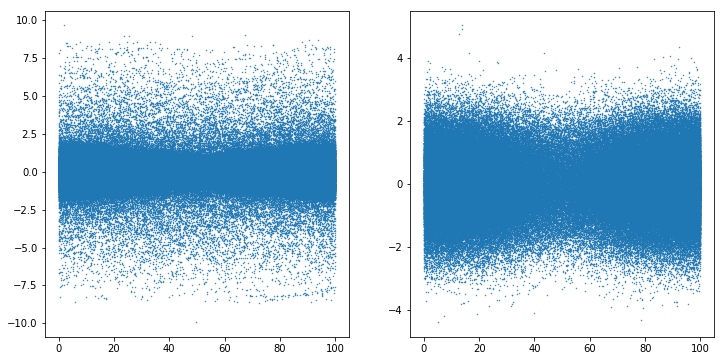

In [326]:
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax1.scatter(xdata[data_num-1],vdata[data_num-1],s=0.2)
ax2 = plt.subplot(122)
ax2.scatter(xdata[0],vdata[0],s=0.2)
plt.show()

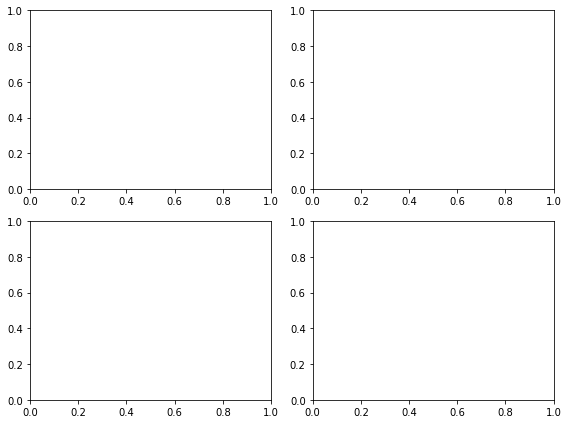

In [327]:
fig = plt.figure(figsize=(8,6))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
plt.tight_layout()

fx_theo = ff(x)
Tx_theo = t_theo(x)
fv_theo = fk_v(v_fv, para[0],para[1])

writer = FFMpegFileWriter(fps=8,bitrate=-1,codec="libx264")
with writer.saving(fig,"kappa-distribution-formation-pic.mp4",dpi=160):
    for frame in range(data_num):
        Z,x_Z,v_Z,dx_Z,dv_Z = pdf2d(xdata[frame],vdata[frame],nx,nv)
        Zx = np.sum(Z,axis=1)*dv_Z
        Zv = np.sum(Z,axis=0)*dx_Z
        T = np.sum(v_Z**2*Z,axis=1)*dv_Z/Zx
        
        ax1.plot(x_Z,Zx*L,'-',color='r')
        ax1.plot(x,fx_theo,'--',color='blue')
        ax1.set_ylim(0.4,1.6)
        ax1.grid()
        ax1.set_title(r'n')
        
        ax2.plot(x_Z,T,'-',color='r')
        ax2.plot(x,Tx_theo, '--',color='blue')
        ax2.set_ylim(0.75,3.25)
        ax2.grid()
        ax2.set_title(r'T')
        
        ax3.plot(v_Z, Zv, '.', color='r')
        ax3.plot(v_fv, fv_theo,'--',color='blue')
        ax3.plot(v_fv0, fv0, '-', color='g')
        ax3.set_xlim(-8,8)
        ax3.set_ylim(10**(-5),1.0)
        ax3.set_yscale('log')
        ax3.grid()
        ax3.set_title(r'v-pdf')
        
        ax4.scatter(xdata[frame],vdata[frame],s=0.2)
        ax4.set_ylim(-8,8)
        ax4.set_title(r'phase space')
        
        writer.grab_frame()
        ax1.cla()
        ax2.cla()
        ax3.cla()
        ax4.cla()